Semantic Segmentation 
============

In this task, you will be focusing on semantic segmentation, a computer vision technique. Unlike image classification, the objective here is not to classify the entire image as a whole, but rather to classify each individual pixel within the image. Consequently, the network's output is not a single value but a segmentation map with the same dimensions as the input image. Think about why convolutional layers are preferable over fully-connected layers for this particular task.


<img src="https://camo.githubusercontent.com/d10b897e15344334e449104a824aff6c29125dc2/687474703a2f2f63616c76696e2e696e662e65642e61632e756b2f77702d636f6e74656e742f75706c6f6164732f646174612f636f636f7374756666646174617365742f636f636f73747566662d6578616d706c65732e706e67">

## (Optional) Mount folder in Colab

Uncomment the following cell to mount your gdrive if you are using the notebook in google colab:

In [48]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_10) is given.

"""
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_10'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))
"""

"\nfrom google.colab import drive\nimport os\n\ngdrive_path='/content/gdrive/MyDrive/i2dl/exercise_10'\n\n# This will mount your google drive under 'MyDrive'\ndrive.mount('/content/gdrive', force_remount=True)\n# In order to access the files in this notebook we have to navigate to the correct folder\nos.chdir(gdrive_path)\n# Check manually if all files are present\nprint(sorted(os.listdir()))\n"

### Set up PyTorch environment in colab
- (OPTIONAL) Enable GPU via Runtime --> Change runtime type --> GPU
- Uncomment the following cell if you are using the notebook in google colab:

In [49]:
# Optional: install correct libraries in google colab
# !python -m pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html
# !python -m pip install tensorboard==2.8.0
# !python -m pip install pytorch-lightning==1.6.0

In [50]:
import sys

# For google colab
# !python -m pip install pytorch-lightning==1.6.0 > /dev/null

# For anaconda/regular python
# !{sys.executable} -m pip install pytorch-lightning==1.6.0 > /dev/null
# 1. Preparation

## Imports

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

from exercise_code.data.segmentation_dataset import SegmentationData, label_img_to_rgb
from exercise_code.data.download_utils import download_dataset
from exercise_code.util import visualizer, save_model
from exercise_code.util.Util import checkSize, checkParams, test
from exercise_code.networks.segmentation_nn import SegmentationNN, DummySegmentationModel
from exercise_code.tests import test_seg_nn

#set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup TensorBoard
In exercise 07 you've already learned how to use TensorBoard. Let's use it again to make the debugging of our network and training process more convenient! As you progress through this notebook, don't hesitate to incorporate additional logs or visualizations in TensorBoard to further enhance your understanding and monitoring of the network's behavior.

In [52]:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs --port 6006

## Load and Visualize Data

#### MSRC-v2 Segmentation Dataset

The MSRC-v2 dataset is an expanded version of the MSRC-v1 dataset, originally created by Microsoft Research in Cambridge. This dataset consists of 591 images, each annotated with accurate pixel-level labels. It contains 23 distinct object classes like bike, bird, car, house or tree.


The image ids are stored in the txt file `train.txt`, `val.txt`, `test.txt`. The dataloader will read the image id in the txt file and fetch the corresponding input and target images from the image folder. 
<img src='images/input_target.png'/>



As you can see in `exercise_code/data/segmentation_dataset.py`, each segmentation label has its corresponding RGB value stored in the `SEG_LABELS_LIST`. The label `void` means `unlabeled`, and it is displayed as black `"rgb_values": [0, 0, 0]` in the target image. The target image pixels will be labeled based on its color using `SEG_LABELS_LIST`.

```python
                SEG_LABELS_LIST = [
                {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
                {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
                {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
                {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
                {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
                {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
                {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
                ...]    
```

<div class="alert alert-block alert-warning">
    <h3>Note: The label <code>void</code></h3>
    <p>Pixels with the label <code>void</code> should neither be considered in your loss nor in the accuracy of your segmentation. See implementation for details.</p>
</div>

In [53]:
download_url = 'https://i2dl.vc.in.tum.de/static/data/segmentation_data.zip'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, 'datasets','segmentation')


download_dataset(
    url=download_url,
    data_dir=data_root,
    dataset_zip_name='segmentation_data.zip',
    force_download=False,
)

train_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/val.txt')
test_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/test.txt')

If you want to implement data augmentation methods, make yourself familiar with the segmentation dataset and how we implemented the `SegmentationData` class in `exercise_code/data/segmentation_dataset.py`. Furthermore, you can check the original label description in `datasets/segmentation/segmentation_data/info.html`.

For now, let's look at a few samples of our training set:

Train size: 276
Validation size: 59
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


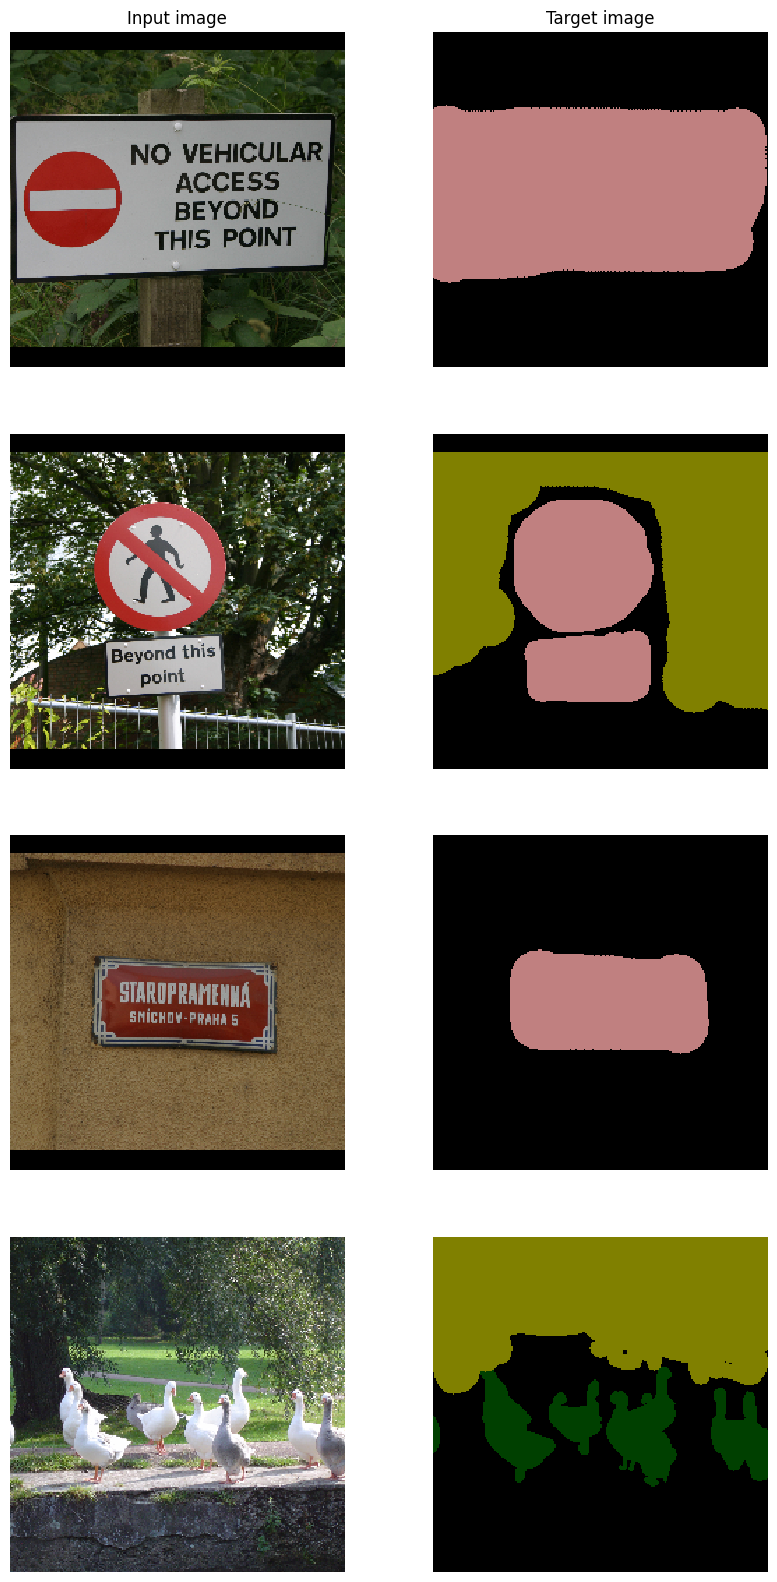

In [54]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 4
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

As you can see, the dataset is considerably smaller when compared to our previous datasets. For instance, CIFAR10 consisted of thousands of images, whereas in this case, we only have 276 training images. Moreover, the task itself is significantly more challenging than a "simple 10 class classification" because we need to assign a label to every individual pixel. What's more, the images are much bigger as we are now considering images of size 240x240 instead of 32x32. 

Given these factors, it's important to set realistic expectations regarding the performance of our networks, so don't be too disappointed.

# 2. Semantic Segmentation 

## Dummy Model

In `exercise_code/networks/segmentation_nn.py` we define a naive `DummySegmentationModel`, which always predicts the scores of segmentation labels of the first image. Let's try it on a few images and visualize the outputs using the `visualizer` we provide. The `visualizer` takes in the model and dataset, and visualizes the first four (Input, Target, Prediction) pairs. 

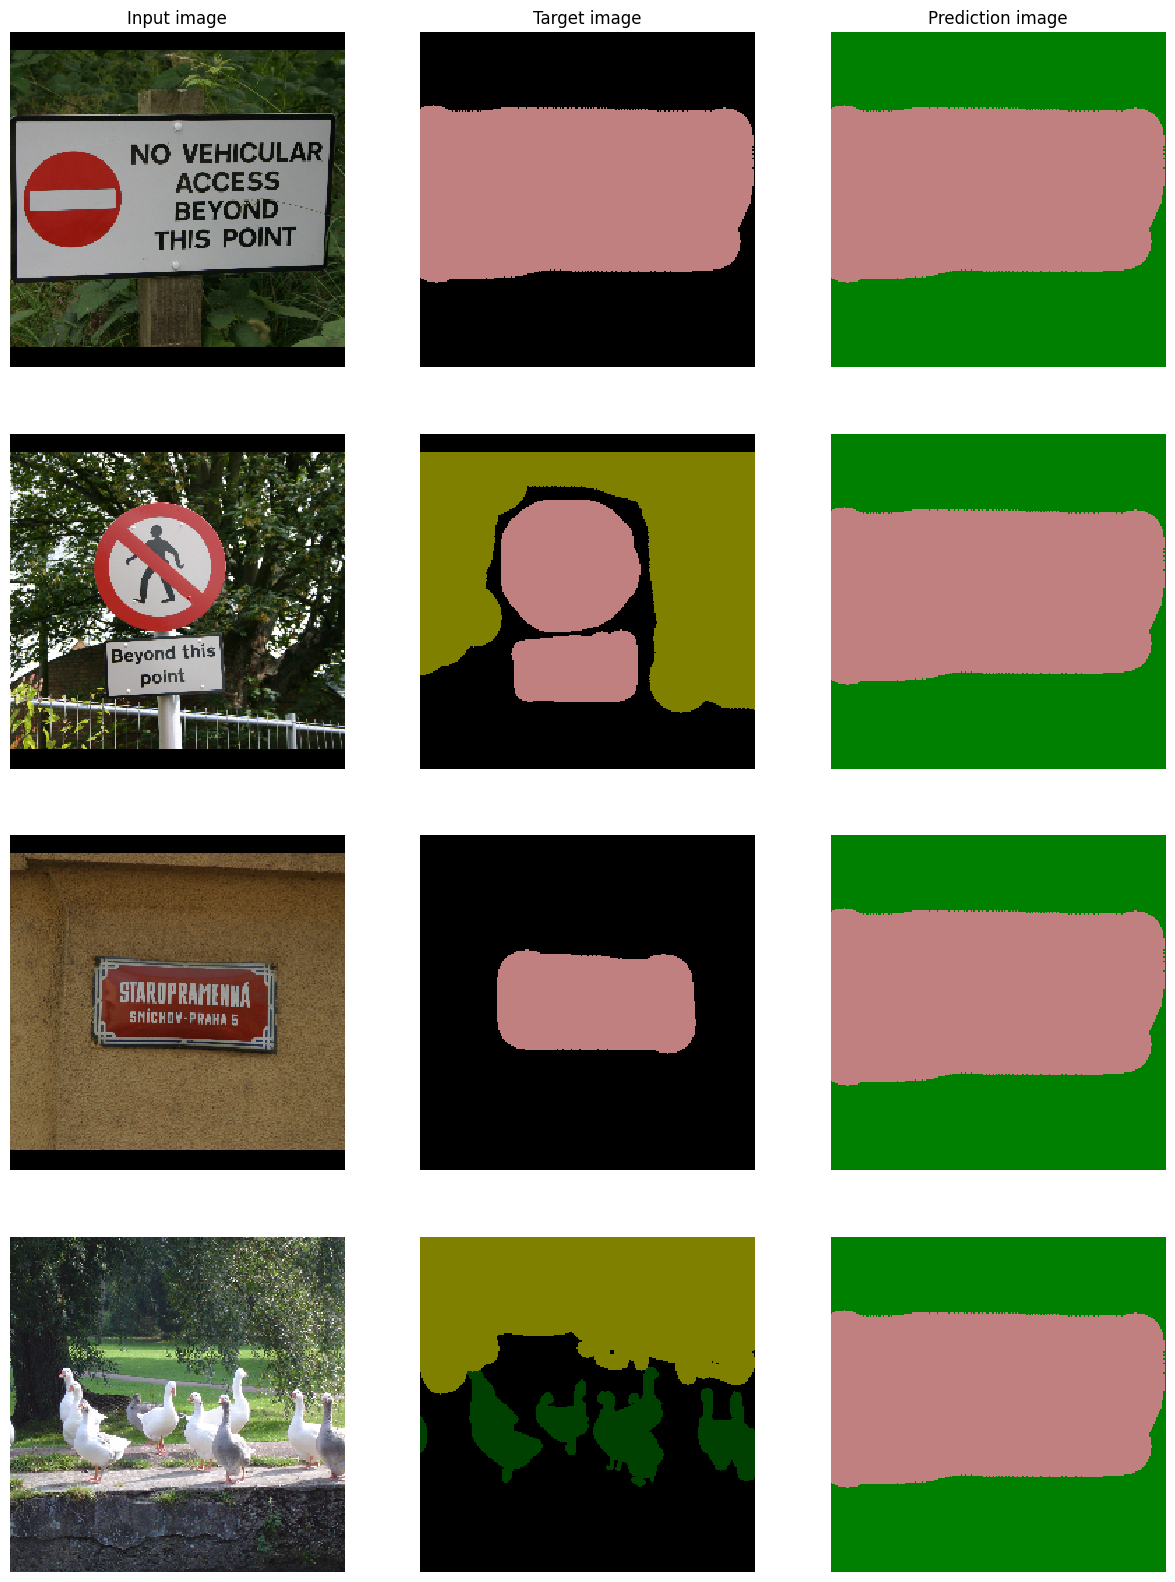

In [55]:
dummy_model = DummySegmentationModel(target_image=train_data[0][1])

# Visualization function
visualizer(dummy_model, train_data)

You can use the visualizer function in your training scenario to print out your model predictions on a regular basis.

## Loss and Metrics
In the context of image segmentation, the loss function employed is pixel-wise cross entropy loss. This particular loss function operates at the pixel level, considering each pixel individually, comparing the class predictions (depth-wise pixel vector) to our one-hot encoded target vector. 
<img src='images/loss_img.png' width=80% height=80%/>
source: https://www.jeremyjordan.me/semantic-segmentation/

Up until now we only used the default loss function (`nn.CrossEntropyLoss`) in our solvers. However, In order to ignore the `unlabeled` pixels for the computation of our loss, we need to use a customized version of the loss for the initialization of our segmentation solver. The `ignore_index` argument of the loss can be used to filter the `unlabeled` pixels and computes the loss only over remaining pixels.


In [56]:
loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')

for (inputs, targets) in train_data[0:4]:
    inputs, targets = inputs, targets
    outputs = dummy_model(inputs.unsqueeze(0))
    losses = loss_func(outputs, targets.unsqueeze(0)).item()
    print("Loss:", losses)

Loss: 2.207542657852173
Loss: 2.9404137134552
Loss: 2.207542896270752
Loss: 3.207542896270752


<div class="alert alert-warning">
    <h3>Note: Non-zero loss for the first sample</h3> 
    <p>The output of our dummy model is one-hot-coded tensor. Since there is <b>softmax</b> function in the <b>nn.CrossEntropyLoss</b> function, the loss is:  
    $$loss(x, class) = - \log \left( \frac{\exp(x[class])}{\Sigma_j \exp (x[j])} \right) = −x[class]+\log \left( \Sigma_j \exp(x[j]) \right)$$
     and the loss will not be zero.    </p>
<p>i.e. for $x=[0, 0, 0, 1],class=3$,$\quad$ the loss: 
$loss(x,class) = -1 +\log(\exp(0)+\exp(0)+\exp(0)+\exp(1)) = 0.7437$ </p>
</div>

To obtain an evaluation accuracy, we can simply compute the average per pixel accuracy of our network for a given image. We will use the following function:

In [57]:
def evaluate_model(model, dataloader):
    test_scores = []
    model.eval()
    model = model.to(device)
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        targets_mask = (targets >= 0).cpu()
        test_scores.append(np.mean((preds.cpu() == targets.cpu())[targets_mask].numpy()))

    return np.mean(test_scores)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False,num_workers=0)
print(evaluate_model(dummy_model, test_loader))

0.14179702232915609


You will see reasonably high numbers as your accuracy when you do the training later. The reason behind that is the fact that most output pixels are of a single class and the network can just overfit to common classes such as "grass".

## Step 1: Design your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement your network architecture in <code>exercise_code/networks/segmentation_nn.py</code>. In this task, you will use pytorch to setup your model.
    </p>
</div>

To compensate for the dimension reduction of a typical convolution layer, you should probably include either a single `nn.Upsample` layer, use a combination of upsampling layers as well as convolutions or even transposed convolutions near the end of your network to get back to the target image shape.

This file is mostly empty but contains the expected class name, and the methods that your model needs to implement (only `forward()` basically). 
The only rules your model design has to follow are:
* Inherit from `torch.nn.Module` or `pytorch_lightning.LightningModule`
* Perform the forward pass in `forward()`. Input dimension is (N, C, H, W) and output dimension is (N, num_classes, H, W)
* Have less than 5 million parameters
* Have a model size of less than 50MB after saving

Furthermore, you need to pass all your hyperparameters to the model in a single dict `hparams`.

<div class="alert alert-warning">
    <h3>Note: Transfer learning</h3>
    <p>In this exercise, we encourage you to do transfer learning as we learned in exercise 8, since this will boost your model performance and save training time. You can import pretrained models from torchvision in your model and use its feature extractor (e.g. <code>alexnet.features</code>) to get the image feature. Feel free to choose more advanced pretrained model like ResNet, MobileNet for your architecture design.</p>       
</div>

See [here](https://pytorch.org/vision/stable/models.html) for more info of the torchvison pretrained models.


In [58]:
""" TODO

- Try out PReLU
- Test out optimizers
- I am getting same output image for everything, that seems very wrong


"""

hparams = {
    "device" : device,
    "num_workers" : 8,
    "epochs" : 20,
    "batch_size" : 64, # TODO: Change to 128 or 256 when doing final big model, but batch size slows learning.
    
    "max_patience" : 5, # Stop early if overfitting, although you never really know
    
    "input_size" : 240 * 240, # RGB image of size 240 x 240 pixels
    "output_size" : 23, # 23 distinct object classes
    
    "learning_rate" : 5e-3, # Optimizer
    "max_lr" : 2e-3, # Used for OneCycleLR optimizer
    "weight_decay" : 1e-8, # ADAM, use to reduce big fluctuations in loss graphs
}

In [59]:
from torchinfo import summary

model = SegmentationNN(hp = hparams)
test_seg_nn(model)

summary(model, input_size=(hparams["batch_size"], 3, 240, 240))

ParamCountTest passed. Your model has 2.637 mio. params.
FileSizeTest passed. Your model is 10.7 MB large
All tests passed for your model. Tests passed: 2/2


Layer (type:depth-idx)                                  Output Shape              Param #
SegmentationNN                                          [64, 23, 240, 240]        --
├─Encoder: 1-1                                          [64, 576, 8, 8]           --
│    └─Sequential: 2-1                                  [64, 576, 8, 8]           --
│    │    └─ConvNormActivation: 3-1                     [64, 16, 120, 120]        464
│    │    └─InvertedResidual: 3-2                       [64, 16, 60, 60]          744
│    │    └─InvertedResidual: 3-3                       [64, 24, 30, 30]          3,864
│    │    └─InvertedResidual: 3-4                       [64, 24, 30, 30]          5,416
│    │    └─InvertedResidual: 3-5                       [64, 40, 15, 15]          13,736
│    │    └─InvertedResidual: 3-6                       [64, 40, 15, 15]          57,264
│    │    └─InvertedResidual: 3-7                       [64, 40, 15, 15]          57,264
│    │    └─InvertedResidual: 3-8       

## Step 2: Train your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p> In addition to the network itself, you will also need to write the code for the model training.
    </p>
</div>

In [60]:

import torch
from exercise_code.networks.segmentation_nn import SegmentationNN
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

def create_tqdm_bar(iterable, desc):
    return tqdm(enumerate(iterable),total=len(iterable), ncols=150, desc=desc)

########################################################################
# TODO - Train Your Model                                              #
########################################################################

# Timm helper code

def train_model(model, train_loader, val_loader, loss_func, tb_logger, epochs=3, name='segmentation'):
    
    # Use for LR scheduling
    optimizer = model.optimizer
    # TODO: Set gamma or factor as hparam, as well as epochs patience
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs * len(train_loader) / 5, gamma=0.7)
    
    # Use this to try and get really small losses. patience is set so that LR updated only every 2 epoch
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=2 * len(train_loader)) 
    
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=model.hparams["max_lr"], steps_per_epoch=len(train_loader), epochs=epochs)
    
    validation_loss = 0
    model = model.to(device)
    
    # Used to end training early if we are starting to overfit
    patience = model.hp["max_patience"]
    best_val_loss = 10e10 # Best val loss of the model so far. Init as unrealistically large
    
    for epoch in range(epochs):        
        
        # Training
        training_loop = create_tqdm_bar(train_loader, desc=f'Training Epoch [{epoch + 1}/{epochs}]')
        training_loss = 0
        for train_iteration, batch in training_loop:
            loss = model.training_step(batch, loss_func)
            training_loss += loss.item()
            scheduler.step() # TODO: Is this right place to do scheduler step?
            
            # Update the progress bar
            training_loop.set_postfix(train_loss = "{:.8f}".format(training_loss / (train_iteration + 1)), lr = "{:.8f}".format(optimizer.param_groups[0]['lr']))
            
            # Update the tensorboard logger.
            tb_logger.add_scalar(f'{name}/train_loss', loss.item(), epoch * len(train_loader) + train_iteration)
            
        # Validation
        val_loop = create_tqdm_bar(val_loader, desc=f'Validation Epoch [{epoch + 1}/{epochs}]')
        validation_loss = 0
        with torch.no_grad(): # Don't actually need because validation_step already has it?
            for val_iteration, batch in val_loop:
                loss = model.validation_step(batch, loss_func)
                validation_loss += loss.item()
                
                # Update the progress bar
                val_loop.set_postfix(patience ="{}".format(patience), val_loss = "{:.8f}".format(validation_loss / (val_iteration + 1)))
                
                # Update the tensorboard logger.
                tb_logger.add_scalar(f'{name}/val_loss', validation_loss / (val_iteration + 1), epoch * len(val_loader) + val_iteration)
        
        scaled_loss =  validation_loss / (val_iteration + 1)# validation_loss is sum of batch losses, we want average
        if scaled_loss <= best_val_loss :
            patience = model.hp["max_patience"]
            best_val_loss = scaled_loss # Rescaled based on batch size
        else:
            patience -= 1
            
        # End program if patience is done
        if patience == 0:
            print(f'Stopping early at epoch {epoch}! (patience done)')
            print(f'Best Val loss: {best_val_loss}. Final Val loss used: {scaled_loss}' )
            break
        
        
        
        # This value is for the progress bar of the training loop.
        validation_loss /= len(val_loader)
        
    print(f'Best Val loss: {best_val_loss}. Final Val loss used: {scaled_loss}' )
 
 
model = SegmentationNN(hp=hparams)

# Create the tb_logger
path = os.path.join('logs', 'segmentation_logs')
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f'run_{num_of_runs + 1}')
tb_logger = SummaryWriter(path)

# Train the model
# TODO: Maybe try to use a small dataset first?
train_loader = torch.utils.data.DataLoader(train_data, batch_size=hparams['batch_size'], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=hparams['batch_size'], shuffle=False)

epochs = hparams.get('epochs', 5)
loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')
train_model(model, train_loader, val_loader, loss_func, tb_logger, epochs=epochs, name='segmentation')


#######################################################################
#                           END OF YOUR CODE                          #
#######################################################################

Validation Epoch [12/20]: 100%|████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it, patience=1, val_loss=2.94198465]

Stopping early at epoch 11! (patience done)
Best Val loss: 2.8628320693969727. Final Val loss used: 2.9419846534729004
Best Val loss: 2.8628320693969727. Final Val loss used: 2.9419846534729004


# 3. Test your Model

In [65]:
test(evaluate_model(model, test_loader))

Validation-Accuracy: 8.45545675186285%
That's too low! Please tune your model in order to reach at least 60.0% before running on the test set and submitting!


# 4. Visualization

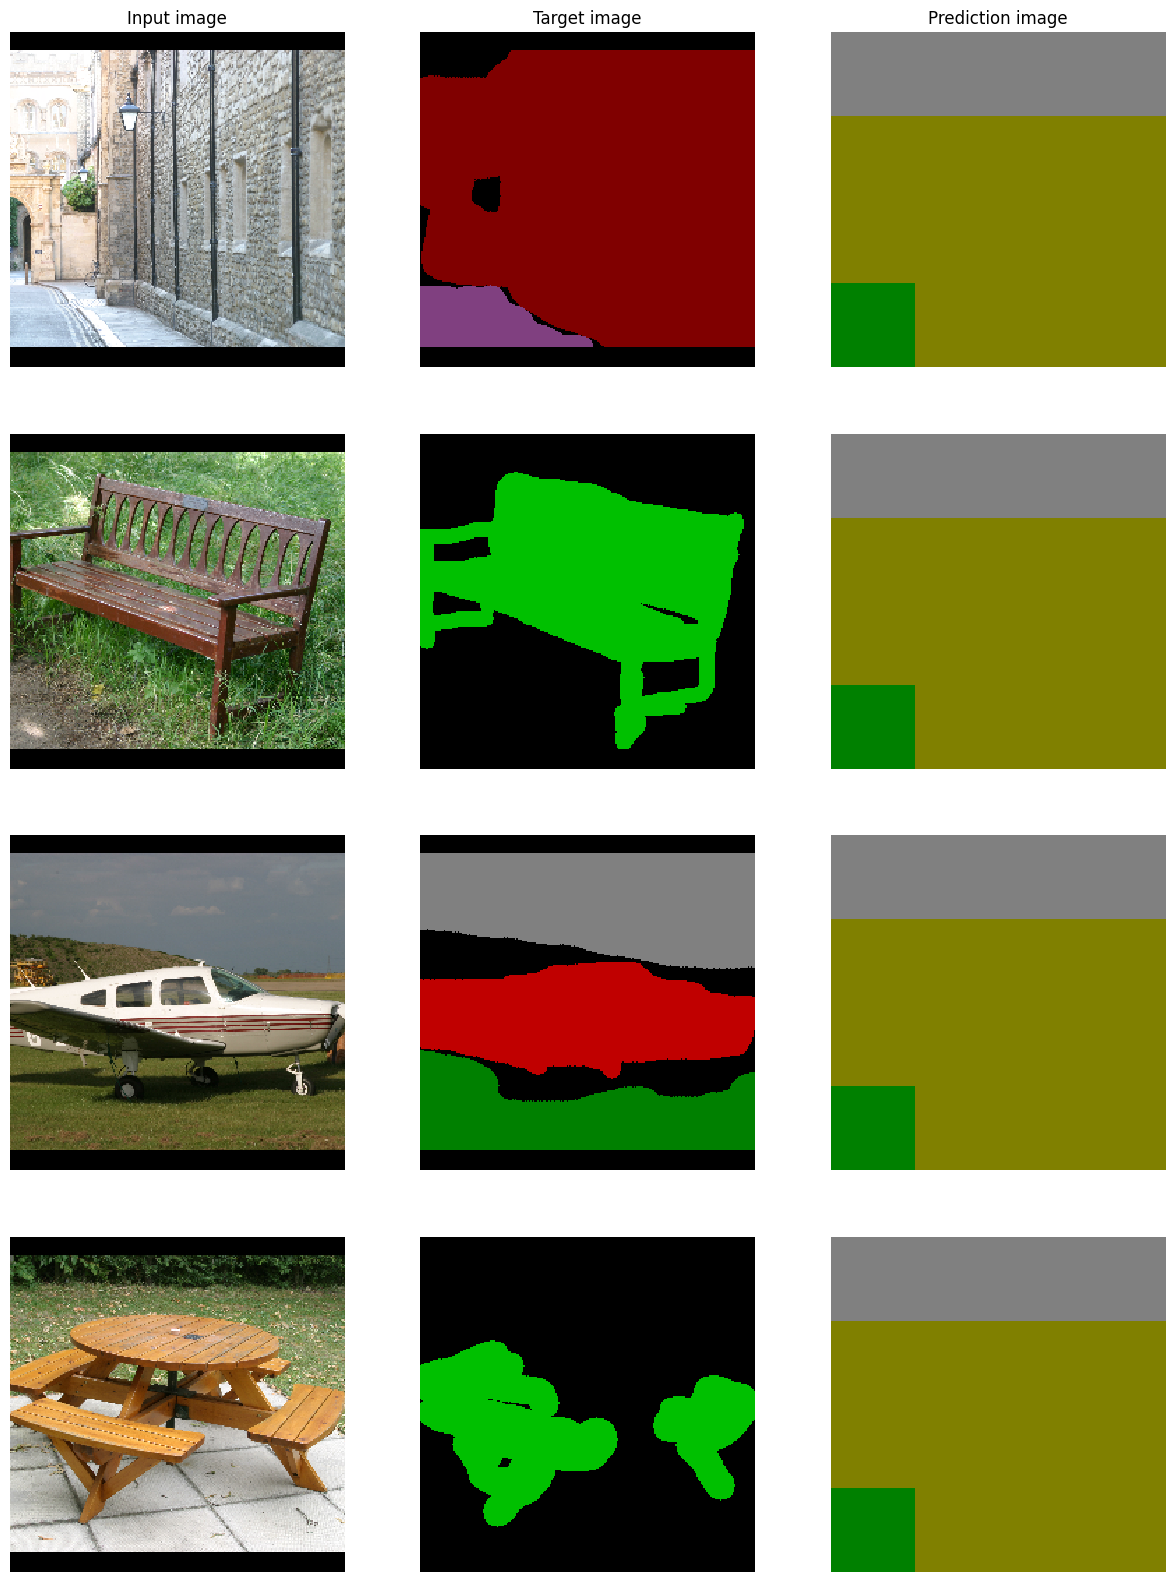

In [66]:
visualizer(model, test_data)

## Save the Model for Submission

 Once you are satisfied with the training of your model, you need to save it for submission. To be eligible for the bonus, you must attain an accuracy exceeding __64%__.

In [69]:
os.makedirs('models', exist_ok=True)
save_model(model, "segmentation_nn.model")
checkSize(path = "./models/segmentation_nn.model")

Great! Your model size is less than 50 MB and will be accepted :)


True

In [70]:
from exercise_code.util.submit import submit_exercise

submit_exercise('../output/exercise10')

relevant folders: ['exercise_code', 'models']
notebooks files: ['1_segmentation_nn.ipynb']
Adding folder exercise_code
Adding folder models
Adding notebook 1_segmentation_nn.ipynb
Zipping successful! Zip is stored under: /home/timm_pop/Documents/i2dl/output/exercise10.zip


# Submission Instructions

Congratulations! You've just built your first semantic segmentation model with PyTorch! To complete the exercise, submit your final model to [the submission server](https://i2dl.vc.in.tum.de/) - you probably know the procedure by now.


# Submission Goals

- Goal: Implement and train a convolutional neural network for Semantic Segmentation.
- Passing Criteria: Reach **Accuracy >= 64%** on __our__ test dataset. The submission system will show you your score after you submit.
- Submission start: __June 29, 2023 - 10:00__
- Submission deadline: __July 05, 2023 - 15:59__
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for bonus

# [Exercise Review](https://docs.google.com/forms/d/e/1FAIpQLSedSHEJ5vN-9FmJN-IGSQ9heDM_8qJQjHL4glgQGlrpQJEYPQ/viewform?usp=pp_url&entry.999074405=Exercise+10:+Semantic+Segmentation)

We are always interested in your opinion. Now that you have finished this exercise, we would like you to give us some feedback about the time required to finish the submission and/or work through the notebooks. Please take the short time to fill out our [review form](https://docs.google.com/forms/d/e/1FAIpQLSedSHEJ5vN-9FmJN-IGSQ9heDM_8qJQjHL4glgQGlrpQJEYPQ/viewform?usp=pp_url&entry.999074405=Exercise+10:+Semantic+Segmentation) for this exercise so that we can do better next time! :)